In [48]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_log_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit

In [49]:
# Training data
df_part1 = pd.read_csv("data/train1.csv", index_col="id")
df_part2 = pd.read_csv("data/train2.csv", index_col="id")

# Concatenate dataframes
train_df = pd.concat([df_part1, df_part2])

# Remaining data

## Exploration


### Training data


In [50]:
print(train_df.shape)
train_df.head()

(3000888, 5)


,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [51]:
# Convert the date column type to datetime
train_df["date"] = pd.to_datetime(train_df["date"])

In [52]:
train_df.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

The datatypes seem reasonable for the data they contain.


In [53]:
print(train_df.family.unique())
train_df.family.unique().shape

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


(33,)

There are 33 product families.


In [54]:
print(train_df.store_nbr.unique())
train_df.store_nbr.unique().shape

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]


(54,)

There are 54 stores.


In [55]:
train_df.isnull().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

The training data doesn't contain any missing values.


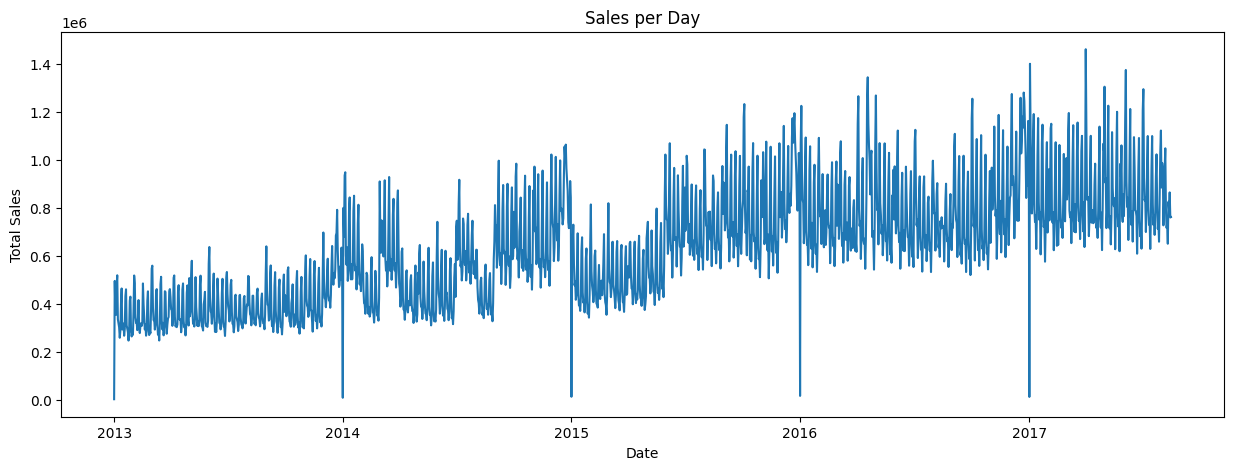

In [56]:
total_sales_per_day = train_df.groupby("date")["sales"].sum().reset_index()
plt.figure(figsize=(15, 5))
plt.plot(total_sales_per_day["date"], total_sales_per_day["sales"])
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Sales per Day")
plt.show()

The general trend is that the data increases with each year. For each year, the sales increase toward the end of the year, then dropping in the beggining of the next year, with a huge spike on the first day of each year.


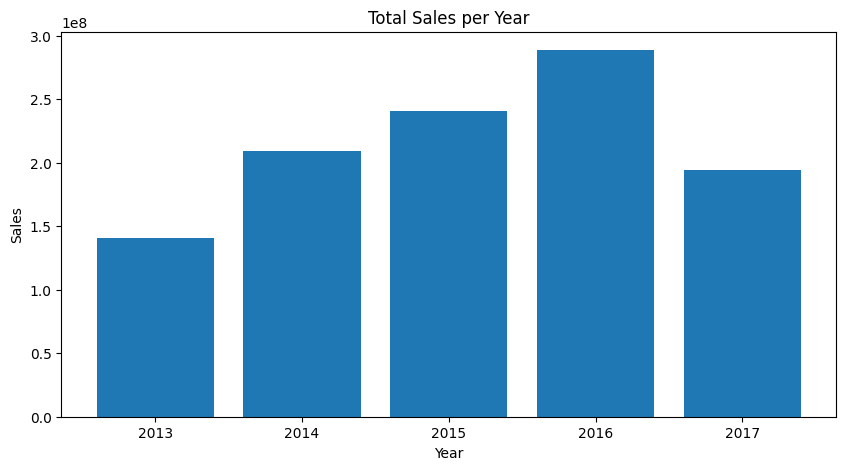

In [57]:
total_sales_per_year = train_df.groupby(train_df["date"].dt.year)["sales"].sum().reset_index()
plt.figure(figsize=(10, 5))
plt.bar(total_sales_per_year["date"], total_sales_per_year["sales"])
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Total Sales per Year")
plt.show()

Here we also see that the sales generally increase each year. 2017 is lower since the dataset doesn't contain data for the entire year.


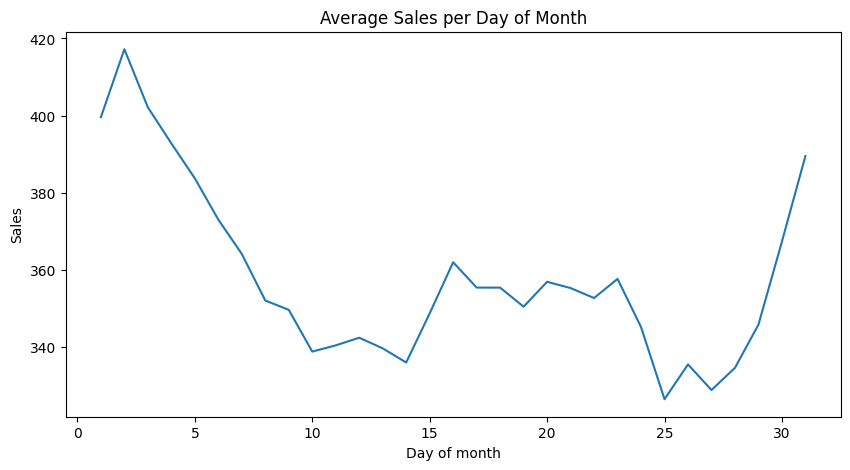

In [58]:
average_sales_per_day_of_month = train_df.groupby(train_df["date"].dt.day)["sales"].mean().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(average_sales_per_day_of_month["date"], average_sales_per_day_of_month["sales"])
plt.xlabel("Day of month")
plt.ylabel("Sales")
plt.title("Average Sales per Day of Month")
plt.show()

We see a peak in the middle of the month and the end of the month due to wages being paid on the 15th and on the last day of the month.


## Pre-processing


### Add features


In [59]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Information
    df["dayofweek"] = df["date"].dt.dayofweek
    df["quarter"] = df["date"].dt.quarter
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["dayofyear"] = df["date"].dt.dayofyear
    df["dayofmonth"] = df["date"].dt.day
    df["weekofyear"] = df["date"].dt.isocalendar().week

    # Lag features
    # df["month_lag"] = df.groupby(["family", "store_nbr"])["sales"].shift(28)
    # df["two_month_lag"] = df.groupby(["family", "store_nbr"])["sales"].shift(56)
    # df["year_lag"] = df.groupby(["family", "store_nbr"])["sales"].shift(364)
    # df["two_year_lag"] = df.groupby(["family", "store_nbr"])["sales"].shift(728)

    # Boolean features
    # df["is_month_midpoint"] = df["date"].dt.day == 15
    # df["is_month_end"] = df["date"].dt.is_month_end

    # Remove now unnecessary features
    df = df.drop("date", axis=1)
    return df

### Create dataframes


In [60]:
# start_idx = train_df.loc[train_df["date"] == "2015-07-01"].index[0]
start_idx = 0
split_idx = train_df.loc[train_df["date"] == "2017-08-01"].index[0]

X_train = create_features(train_df)

y_train = X_train["sales"]
X_train = X_train.drop("sales", axis=1)

X_test = X_train[split_idx:]
y_test = y_train[split_idx:]

X_train = X_train[start_idx:split_idx]
y_train = y_train[start_idx:split_idx]

X_train.tail()

,store_nbr,family,onpromotion,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
id,,,,,,,,,,
2974153,9,POULTRY,1,0,3,7,2017,212,31,31
2974154,9,PREPARED FOODS,0,0,3,7,2017,212,31,31
2974155,9,PRODUCE,6,0,3,7,2017,212,31,31
2974156,9,SCHOOL AND OFFICE SUPPLIES,6,0,3,7,2017,212,31,31
2974157,9,SEAFOOD,0,0,3,7,2017,212,31,31


### Create pipeline


In [61]:
CATEGORICAL_FEATURES = ["family"]
CONTINOUS_FEATURES = []

# Create a pipeline for categorical features
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[("cat", cat_pipeline, CATEGORICAL_FEATURES)], remainder="passthrough", force_int_remainder_cols=False
)

# Create the model
model = xgb.XGBRegressor(objective="reg:tweedie", random_state=0)

# Create the final pipeline
pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])

## Model training


In [62]:
# Testing with a smaller dataset because of small RAM size on laptop, remove when on PC.
X_train_mini = X_train.iloc[-1000000:]
y_train_mini = y_train.iloc[-1000000:]

RMSLE for fold 0: 0.60
RMSLE for fold 1: 0.53
RMSLE for fold 2: 0.54
RMSLE for fold 3: 0.62
RMSLE for fold 4: 0.59
Average RMSLE: 0.58


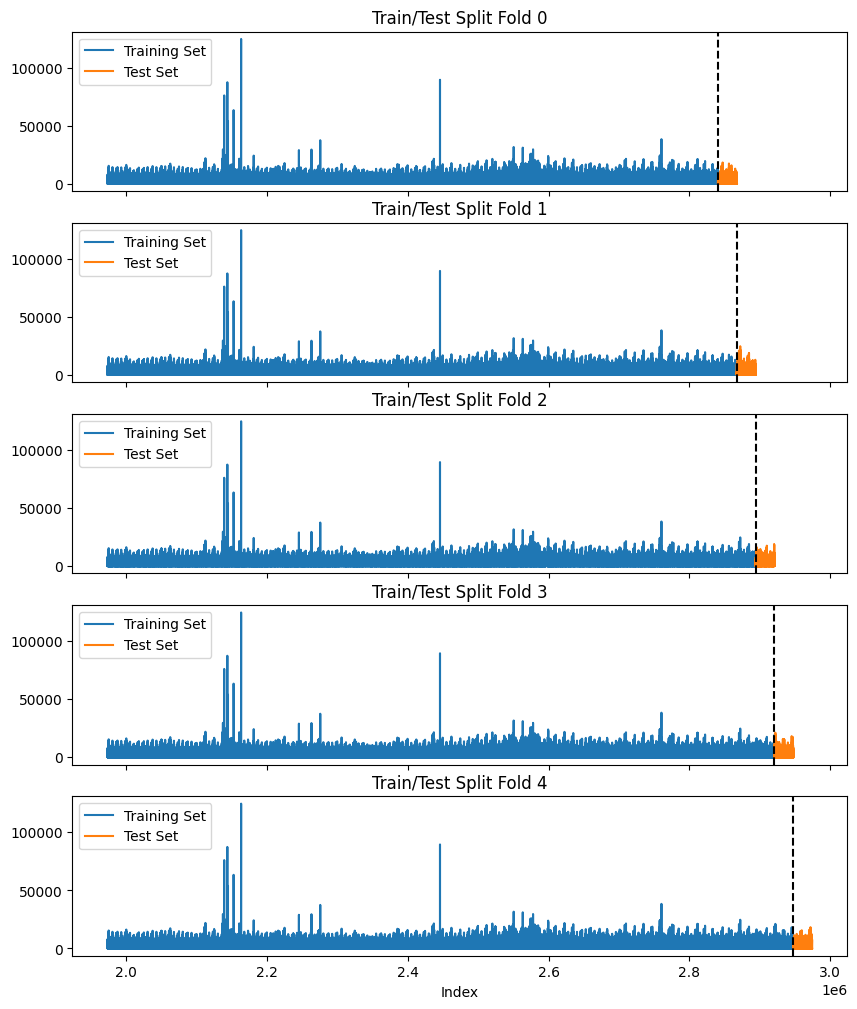

In [63]:
# Test size is 15 days
tss = TimeSeriesSplit(n_splits=5, test_size=33 * 54 * 15)
scores = []
fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

for fold, (train_index, test_index) in enumerate(tss.split(X_train_mini)):
    X_train_cv, X_test_cv = X_train_mini.iloc[train_index], X_train_mini.iloc[test_index]
    y_train_cv, y_test_cv = y_train_mini.iloc[train_index], y_train_mini.iloc[test_index]

    axes[fold].plot(y_train_cv, label="Training Set")
    axes[fold].plot(y_test_cv, label="Test Set")
    axes[fold].axvline(y_test_cv.index.min(), color="black", ls="--")
    axes[fold].legend()
    axes[fold].set_title(f"Train/Test Split Fold {fold}")

    pipeline.fit(X_train_cv, y_train_cv)
    y_pred = pipeline.predict(X_test)

    score = root_mean_squared_log_error(y_test, y_pred)
    scores.append(score)
    print(f"RMSLE for fold {fold}: {score:.2f}")

average_score = np.mean(scores)
print(f"Average RMSLE: {average_score:.2f}")

plt.xlabel("Index")
plt.show()

In [ ]:
# Train full mini model
pipeline.fit(X_train_mini, y_train_mini)

In [18]:
# Train full model
# pipeline.fit(X_train, y_train)

### Validation


In [19]:
mini_test_size = int(len(y_train_mini) * len(y_test) / len(y_train))
mini_test_size

8987

#### Baseline


In [47]:
full_data = X_train_mini.copy()
full_data["sales"] = y_train_mini
last_sales = full_data.groupby(["store_nbr", "family"])["sales"].mean().reset_index()
baseline_pred = pd.merge(X_test[:mini_test_size], last_sales, on=["store_nbr", "family"], how="left")["sales"].values
print("RMSLE:", round(root_mean_squared_log_error(y_test[:mini_test_size], baseline_pred), 4))

RMSLE: 0.5593


0.5593


#### Final model


In [ ]:
y_pred = pipeline.predict(X_test[:mini_test_size])
print("RMSLE:", round(root_mean_squared_log_error(y_test[:mini_test_size], y_pred), 4))

RMSLE: 0.5133


0.5133


In [22]:
# y_pred = pipeline.predict(X_test)
# print("RMSLE:", round(root_mean_squared_log_error(y_test, y_pred), 4))